## Compute the azimuth and elevation phase maps

1. Compute the fft of each stimulation
2. To correct for phase delays subtract the phase of stimuli moving in opposite directions
3. Plot stimuli phase as time.

In [1]:
from wfield import *
import pandas as pd
from tifffile import imwrite

### 路径和刺激重复次数。（本代码对应的是每个方向连续重复10次再下一个方向）
path_merge = 'Z:\\WF_VC_liuzhaoxi\\23.10.10_G360_gp4.3\\retinotopy_10x4\\process\\20231010-171539-merged'
nrepeats = 10
post_trial = 3   # 刺激消失后多取几秒

path_out = pjoin(path_merge, '..', os.path.basename(path_merge)[:16]+'retinotopy')
os.makedirs(path_out, exist_ok=True)


In [2]:
### load data
trials = pd.read_csv(pjoin(path_merge, "trials.csv"), header=None, dtype=int).values
nframes_el = min(trials[:20, 3]) + post_trial*10
nframes_az = min(trials[20:40, 3]) + post_trial*10
U = np.load(pjoin(path_merge, 'U.npy'))
SVTcorr = np.load(pjoin(path_merge, 'SVTcorr.npy'))
nSVD = SVTcorr.shape[0]


### extract trial-data for 4 direction stimuli respectively.
def _sort_frames(nframes, *ntrials):
    avg = np.empty((nSVD, 0, nframes))
    raw = np.empty((nSVD, 0))
    for i in ntrials:
        avg = np.concatenate((avg, SVTcorr[:, trials[i, 1]:trials[i, 1] + nframes].reshape(nSVD, 1, nframes)), axis=1)
        raw = np.concatenate((raw, SVTcorr[:, trials[i, 1]:trials[i, 1] + nframes]), axis=1)
    avg = np.mean(avg, axis=1)
    return avg, raw

avg_up, raw_up = _sort_frames(nframes_el, *range(nrepeats * 0, nrepeats * 1))
avg_down, raw_down = _sort_frames(nframes_el, *range(nrepeats * 1, nrepeats * 2))
avg_left, raw_left = _sort_frames(nframes_az, *range(nrepeats * 2, nrepeats * 3))
avg_right, raw_right = _sort_frames(nframes_az, *range(nrepeats * 3, nrepeats * 4))


In [3]:
### computes fft in SVD space

%matplotlib inline

# from scipy.ndimage import gaussian_filter,median_filter
# mov = runpar(median_filter, U.transpose((2, 0, 1)), size=5)
# U1 = np.stack(mov).transpose((1, 2, 0)).astype(np.float32)
up = reconstruct(U, fft(raw_up.T, axis=0)[nrepeats])
down = reconstruct(U, fft(raw_down.T, axis=0)[nrepeats])
left = reconstruct(U, fft(raw_left.T, axis=0)[nrepeats])
right = reconstruct(U, fft(raw_right.T, axis=0)[nrepeats])
phase_el = -1. * (np.angle(up) - np.angle(down)) % (2 * np.pi)
mag_el = (np.abs(up + down) * 2.)
phase_az = -1. * (np.angle(left) - np.angle(right)) % (2 * np.pi)
mag_az = (np.abs(left + right) * 2.)


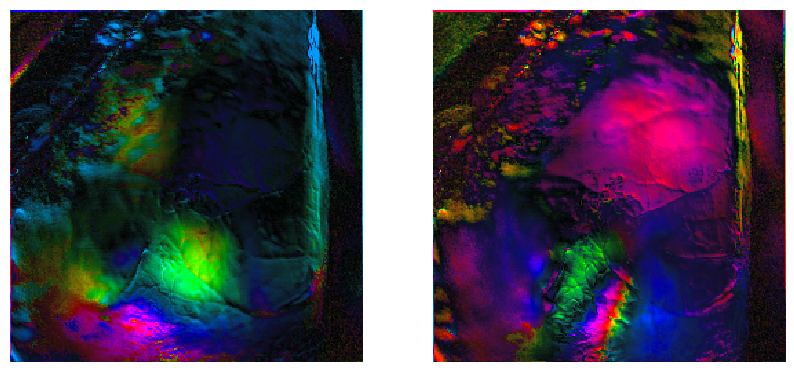

In [7]:
### plot phase maps

fig = plt.figure(figsize=[10, 5])
fig.add_subplot(1, 2, 1)
plt.imshow(im_fftphase_hsv([mag_el, phase_el], return_hsv=False))
plt.axis('off')
fig.add_subplot(1, 2, 2)
plt.imshow(im_fftphase_hsv([mag_az, phase_az], return_hsv=False))
plt.axis('off')
fig.set_facecolor('white')
# plt.savefig(pjoin(path_out, 'el_az_unfiltered.png'))


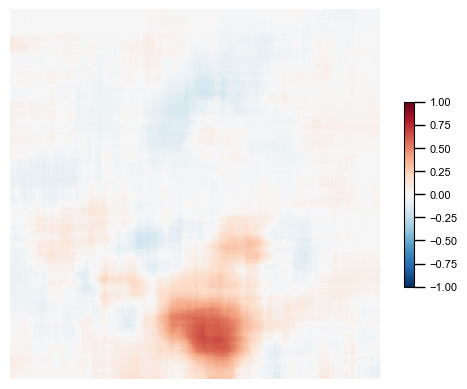

In [8]:
### plot sign maps

from scipy.ndimage import median_filter
fig = plt.figure()
plt.imshow(median_filter(visual_sign_map(phase_az, phase_el), 33),
           cmap='RdBu_r', clim=[-1, 1])
plt.colorbar(shrink=0.5)
plt.axis('off')
fig.set_facecolor('white')
# plt.savefig(pjoin(path_out, 'phasemap.png'))


In [40]:
### export trial-average tif

imwrite(pjoin(path_out, 'avg_up.tif'), reconstruct(U, avg_up).astype('float32'), imagej=True)
imwrite(pjoin(path_out, 'avg_down.tif'), reconstruct(U, avg_down).astype('float32'), imagej=True)
imwrite(pjoin(path_out, 'avg_left.tif'), reconstruct(U, avg_left).astype('float32'), imagej=True)
imwrite(pjoin(path_out, 'avg_right.tif'), reconstruct(U, avg_right).astype('float32'), imagej=True)
print('Finish exporting trial-average tif')


Finish exporting trial-average tif


In [41]:
### export phase and magnitude

np.save(pjoin(path_out, 'phase_el.npy'), phase_el)
np.save(pjoin(path_out, 'phase_az.npy'), phase_az)
np.save(pjoin(path_out, 'mag_el.npy'), mag_el)
np.save(pjoin(path_out, 'mag_az.npy'), mag_az)
